In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from dask.diagnostics import ProgressBar
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict
import re
import json

import common
import vcm
import fv3viz

In [2]:
plt.style.use(["tableau-colorblind10"])

In [3]:
online = "zc-emu-1year-run-normfix-precpd-clip-v1-online"
online_default = "zc-emu-1year-run-normfix-v1-online"
# offline = "zc-emu-monthly-seed5-m09-30d-v1-offline"


In [4]:
def _get_run_filename(run, match_str):
    for f in run.files():
        if re.search(match_str, f.name) is not None:
            return f.download(replace=True)

def get_pr_skill_series(run):
    pr_skill = _get_run_filename(run, "skill_time")
    json_payload = json.loads(str(pr_skill.read()))
    data = json_payload["data"]   # list of (time, skill) pairs
    times, pr_sk_series = zip(*data)
    pr_sk_series = np.array(pr_sk_series)
    times = np.array(times, dtype="datetime64[s]")
    return times, pr_sk_series

def get_run_pr_skill(group):
    run = common._get_runs(group)[0]
    return get_pr_skill_series(run)

def get_c_skill_time_height(run):
    c_skill = _get_run_filename(run, "skill/time_vs_lev/precpd/cloud_water")
    data = common._plotly_2d_data_to_array(c_skill)
    return data

def get_run_c_skill(group):
    run = common._get_runs(group)[0]
    return get_c_skill_time_height(run)

In [9]:
times, pr_sk_series = get_run_pr_skill(online)
_, pr_sk_series_default = get_run_pr_skill(online_default)

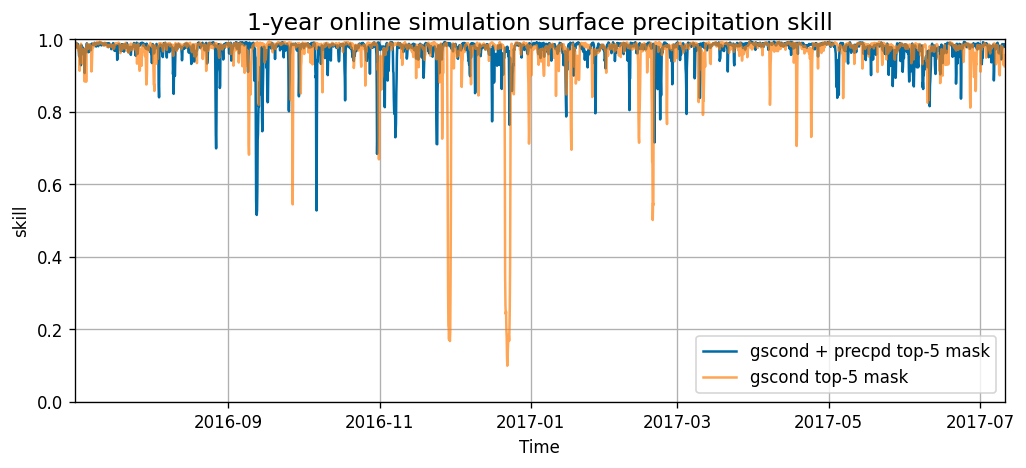

In [46]:
plt.figure(dpi=120, figsize=(10, 4))
plt.plot(times, pr_sk_series, label="gscond + precpd top-5 mask")
plt.plot(times, pr_sk_series_default, label="gscond top-5 mask", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("skill")
plt.title("1-year online simulation surface precipitation skill", size=14)
plt.xlim(times[0], times[-1])
plt.ylim(0, 1)
plt.grid()
plt.legend(loc="lower right")
common.savefig("sup_pr_skill_1year")
plt.show()

In [ ]:
# find lowest skill
# plot precpd cloud skill a +/- 1 day range around it
# make cross plot of surface precipitation to find locations responsible for most of skill drop
# take note of top 3-5 locations and effect on skill
# Plot a vertical profile of the precpd cloud tendency in the emulator and diagnostic fortran
# try the same plot for a few times before and after to

In [6]:
default_data = common.open_group(online_default)
prpd_mask_data = common.open_group(online) 

## Masked Investigation

In [10]:
min_skill = pr_sk_series.argmin()

In [8]:
prpd_mask_c_skill = get_run_c_skill(online)

In [64]:
def plot_skill_focus(data, center_time_idx, time_pad=3*8):
    da = xr.DataArray(data["z"], dims=["z", "time"])
    da.coords["time"] = np.array(data["x"], dtype="datetime64[s]")
    da.coords["z"] = data["y"]
    da = da.isel(time=slice(center_time_idx-time_pad, center_time_idx+time_pad))
    da.plot(x="time", y="z", cmap="RdBu_r", vmin=-1, vmax=1, yincrease=False, cbar_kwargs={"label": "skill"}, rasterized=True)

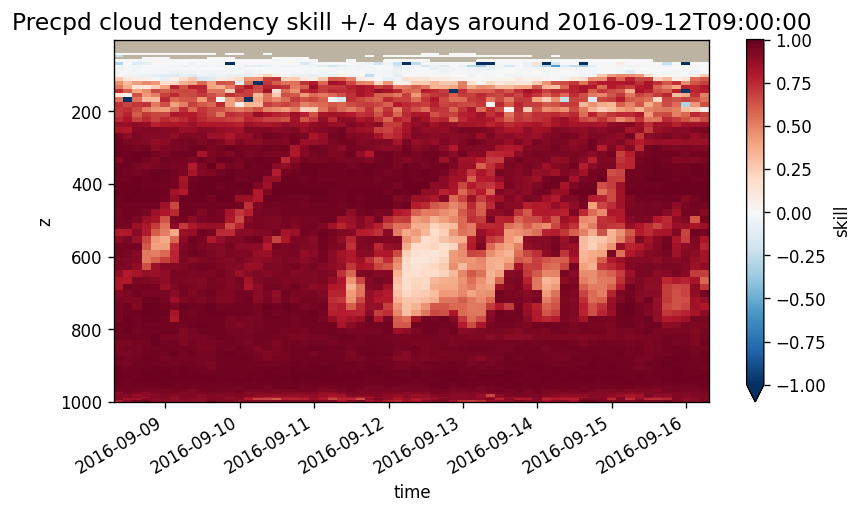

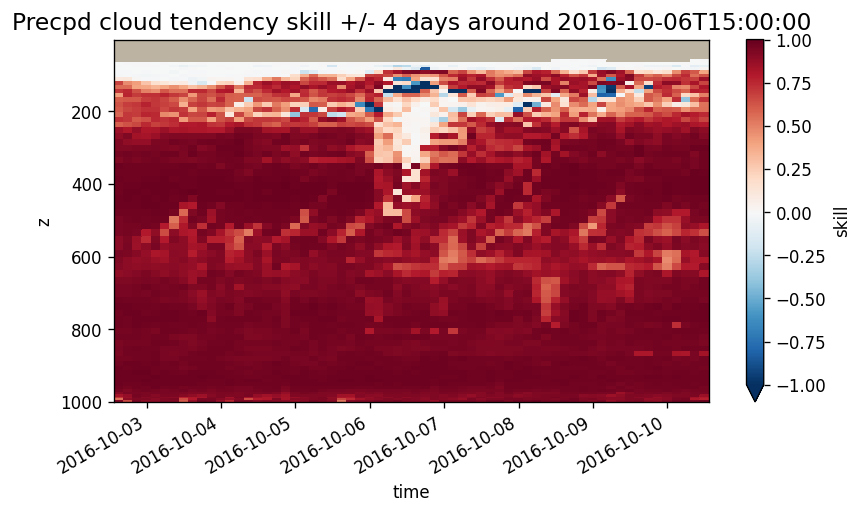

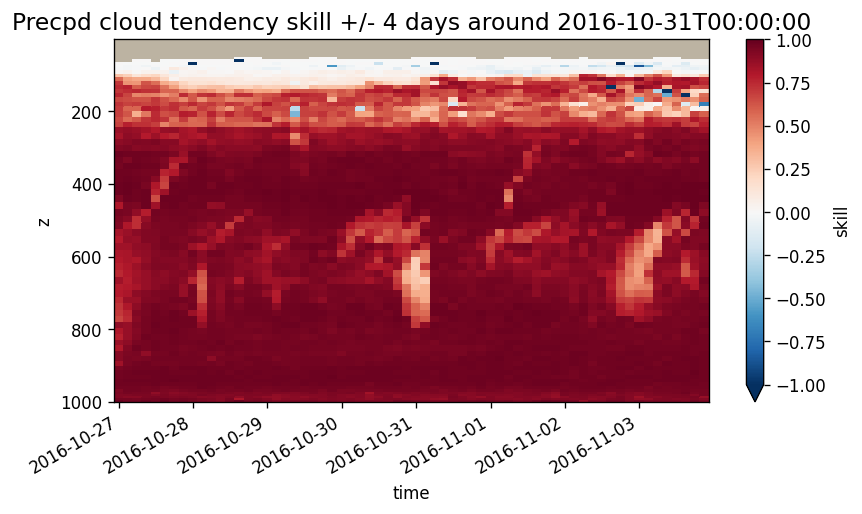

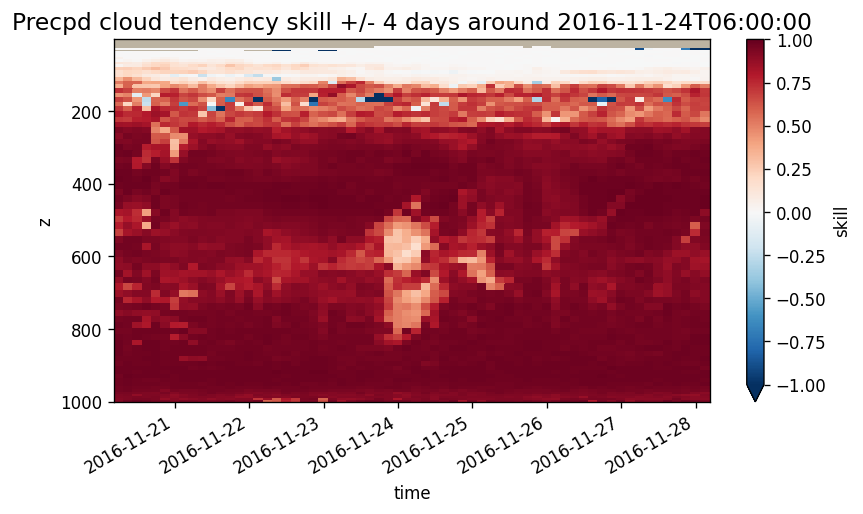

In [81]:
last_idx = -16
num_lowest = 10
for i in np.argpartition(pr_sk_series, 10, axis=0)[:10]:
    if i - last_idx < 8:
        continue
    plt.figure(figsize=(8, 4), dpi=120)
    plot_skill_focus(prpd_mask_c_skill, i, time_pad=4*8)
    plt.title(f"Precpd cloud tendency skill +/- 4 days around {times[i]}", size=14)
    plt.show()
    last_idx = i

## Gscond-only Mask

In [11]:
min_skill_default = pr_sk_series_default.argmin()
default_c_skill = get_run_c_skill(online_default)


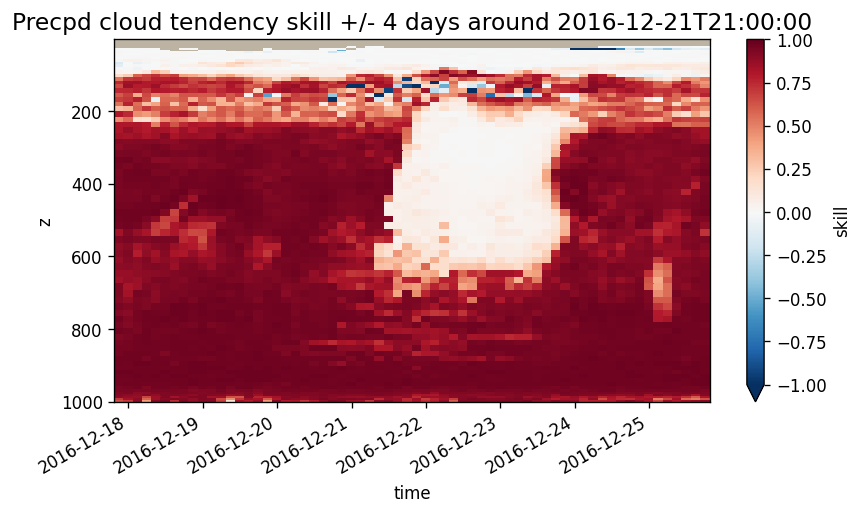

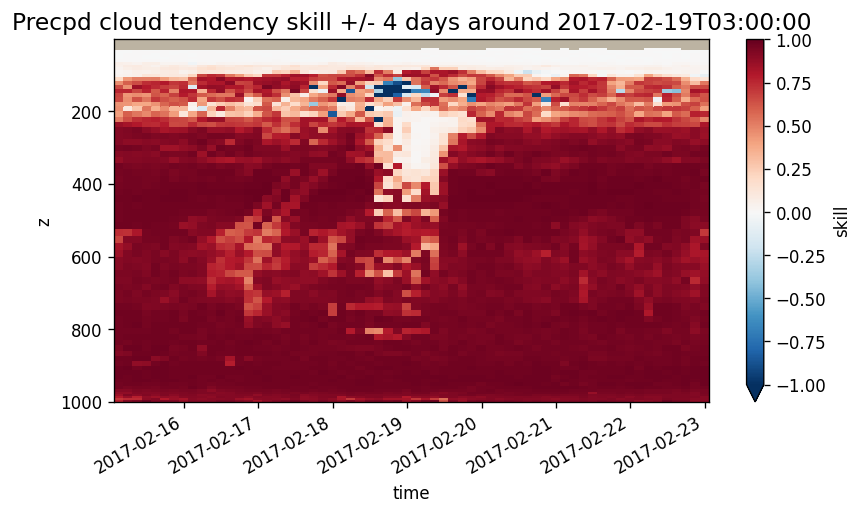

In [87]:
last_idx = -24
num_lowest = 30
for i in np.argpartition(pr_sk_series_default, num_lowest, axis=0)[:num_lowest]:
    if i - last_idx < 16:
        continue
    plt.figure(figsize=(8, 4), dpi=120)
    plot_skill_focus(default_c_skill, i, time_pad=4*8)
    plt.title(f"Precpd cloud tendency skill +/- 4 days around {times[i]}", size=14)
    plt.show()
    last_idx = i

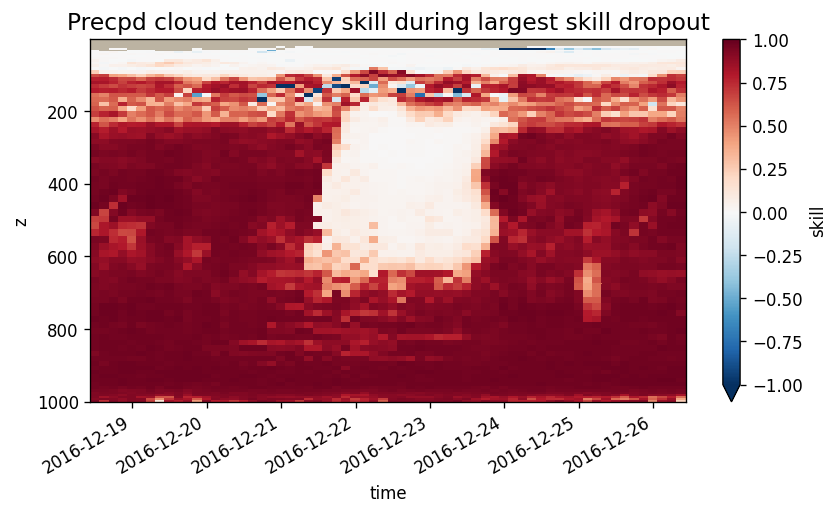

In [66]:

plt.figure(figsize=(8, 4), dpi=120)
plot_skill_focus(default_c_skill, min_skill_default, time_pad=4*8)
plt.title(f"Precpd cloud tendency skill during largest skill dropout", size=14)
common.savefig("app_precpd_skill_1year_default")
plt.show()

In [62]:
def _get_total_gscond_precpd(data, varkey, source):
    template = "tendency_of_{varkey}_due_to_{subroutine}_{source}"
    gscond_key = template.format(varkey=varkey, subroutine="gscond", source=source)
    total_key = template.format(varkey=varkey, subroutine="zhao_carr", source=source)

    gscond = data[gscond_key]
    total = data[total_key]
    precpd = total - gscond
    return total, gscond, precpd


def get_tendencies(data, varkey):

    fort_tends = _get_total_gscond_precpd(data, varkey, "physics")
    emu_tends = _get_total_gscond_precpd(data, varkey, "emulator")

    return fort_tends, emu_tends


def _plot_vertical(emu, phys, isel_kwargs, plot_kwargs):
    emu.isel(**isel_kwargs).plot(y="z", **plot_kwargs, label="Emulator")
    phys.isel(**isel_kwargs).plot(y="z", **plot_kwargs, linestyle="--", label="Fortran")


def plot_tendency_profiles(data, varkey, time_idx):

    time_selected = data.isel(time=time_idx)
    fort_tends, emu_tends = get_tendencies(time_selected, varkey)
    max_total_err = np.abs(fort_tends[0] - emu_tends[0]).argmax()
    tile, z, y, x = np.unravel_index(max_total_err, fort_tends[0].shape)

    isel_kwargs = {"tile": tile, "y": y, "x": x}
    for e, f in zip(emu_tends, fort_tends):
        plt.figure(figsize=(4, 6), dpi=120)
        _plot_vertical(e, f, isel_kwargs, {"yincrease": False})
        plt.ylabel("Reference pressure (hPa)")
        plt.legend(loc="lower left")
        plt.show()

def plot_tendency_profiles_time(data, varkey, time_idx):

    time_selected = data.isel(time=time_idx)
    fort_tends, emu_tends = get_tendencies(time_selected, varkey)
    max_total_err = np.abs(fort_tends[0] - emu_tends[0]).argmax()
    tile, z, y, x = np.unravel_index(max_total_err, fort_tends[0].shape)

    loc_selected = data.isel(tile=tile, y=y, x=x)
    fort_tends, emu_tends = get_tendencies(loc_selected, varkey)
    fort_precpd = fort_tends[2]
    emu_precpd = emu_tends[2]

    plt.figure(figsize=(4, 6), dpi=120)
    for i in range(0, 16, 4):
        new_time = time_idx - i
        _plot_vertical(emu_precpd, fort_precpd, {"time": new_time}, {"yincrease": False})
    plt.ylabel("Reference pressure (hPa)")
    plt.legend(loc="lower left")
    plt.show()

    
    fort_gscond = fort_tends[1]
    emu_gscond = emu_tends[1]

    plt.figure(figsize=(4, 6), dpi=120)
    for i in range(0, 8, 2):
        new_time = time_idx - i
        _plot_vertical(emu_gscond, fort_gscond, {"time": new_time}, {"yincrease": False})
    plt.ylabel("Reference pressure (hPa)")
    plt.legend(loc="lower left")
    plt.show()


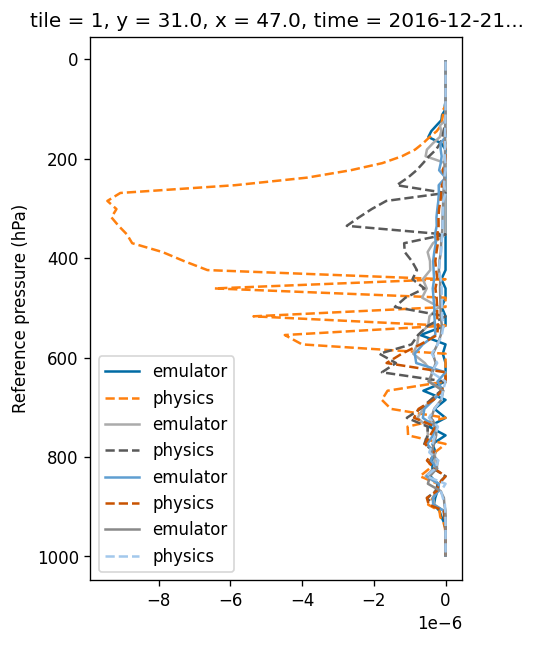

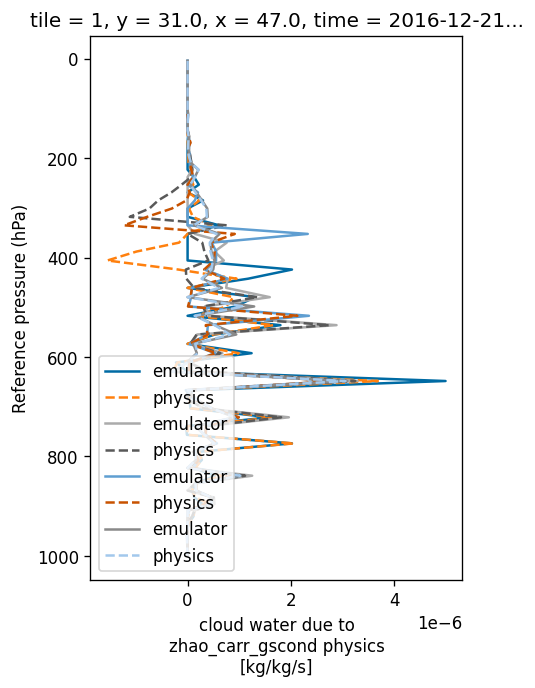

In [129]:
plot_tendency_profiles_time(default_data, "cloud_water", min_skill_default)

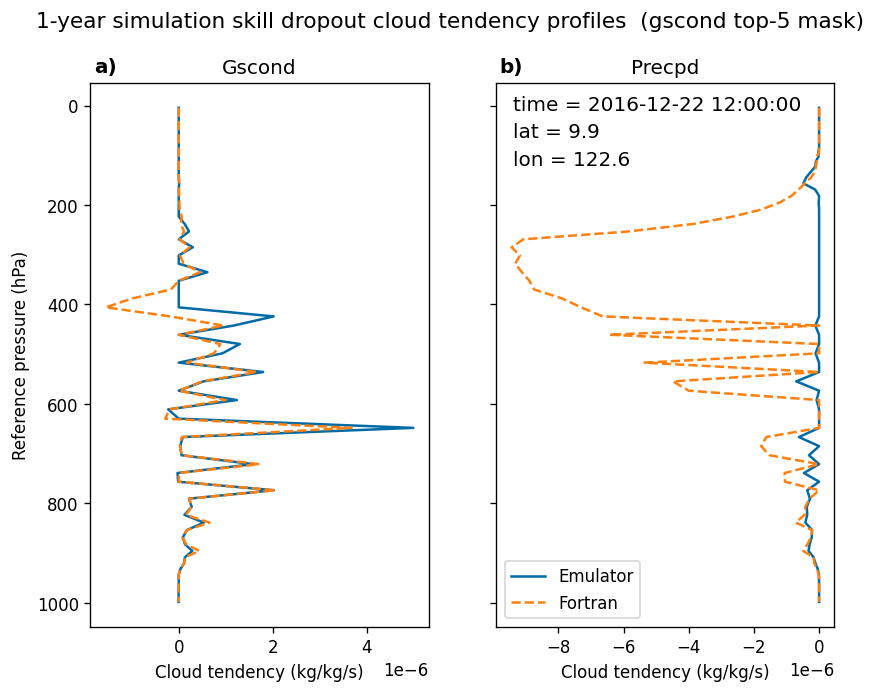

In [63]:
time_selected = default_data.isel(time=min_skill_default)
fort_tends, emu_tends = get_tendencies(time_selected, "cloud_water")
max_total_err = np.abs(fort_tends[0] - emu_tends[0]).argmax()
tile, z, y, x = np.unravel_index(max_total_err, fort_tends[0].shape)

_, emu_gscond, emu_precpd = emu_tends
_, fort_gscond, fort_precpd = fort_tends
isel_kwargs = {"tile": tile, "y": y, "x": x}

lat = default_data.lat.isel(**isel_kwargs).values
lon = default_data.lon.isel(**isel_kwargs).values
time = default_data.time.isel(time=min_skill_default).values

fig, ax = plt.subplots(1, 2, figsize=(8, 6), dpi=120, sharey=True)
_plot_vertical(emu_gscond, fort_gscond, isel_kwargs, {"yincrease": False, "ax": ax[0]})
ax[0].set_ylabel("Reference pressure (hPa)")
ax[0].set_xlabel("Cloud tendency (kg/kg/s)")
ax[0].set_title("Gscond")

_plot_vertical(emu_precpd, fort_precpd, isel_kwargs, {"yincrease": False, "ax": ax[1]})
ax[1].legend(loc="lower left")
ax[1].set_xlabel("Cloud tendency (kg/kg/s)")
ax[1].set_title("Precpd")
ax[1].set_ylabel("")
ax[1].text(0.05, 0.95, f"time = {time}", transform=ax[1].transAxes, size=12)
ax[1].text(0.05, 0.9, f"lat = {lat:1.1f}", transform=ax[1].transAxes, size=12)
ax[1].text(0.05, 0.85, f"lon = {lon:1.1f}", transform=ax[1].transAxes, size=12)

ax[0].text(0.01, 1.02, "a)", transform=ax[0].transAxes, size=12, weight="bold")
ax[1].text(0.01, 1.02, "b)", transform=ax[1].transAxes, size=12, weight="bold")
plt.suptitle("1-year simulation skill dropout cloud tendency profiles  (gscond top-5 mask)", size=13)
common.savefig("app_precpd_skill_miss")
plt.show()

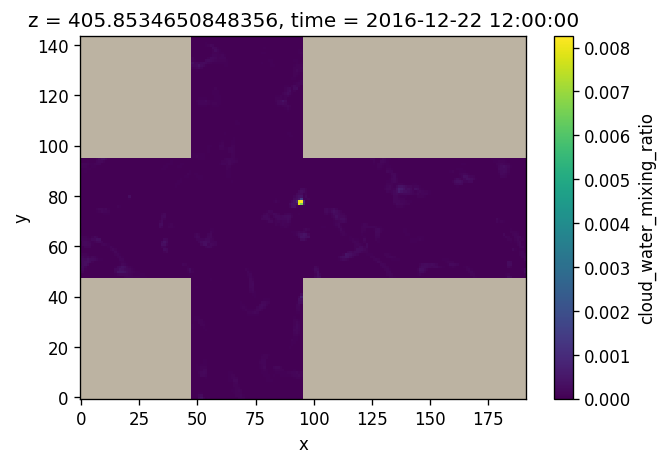

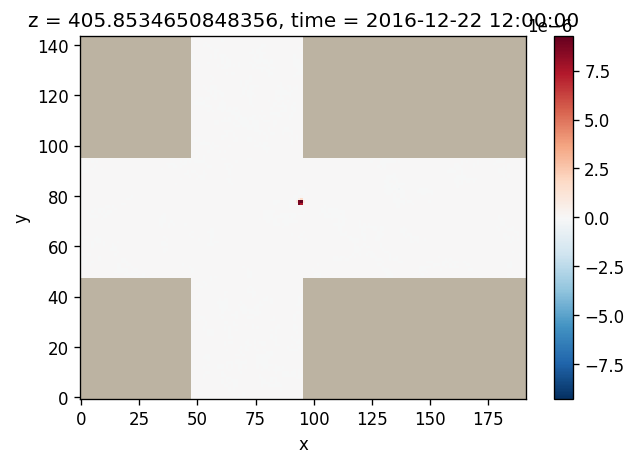

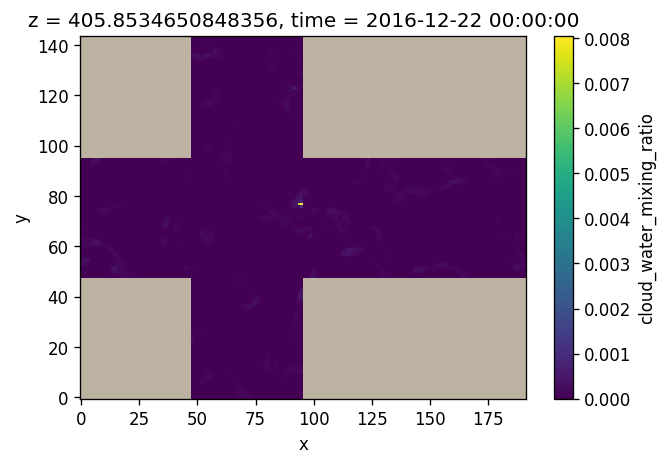

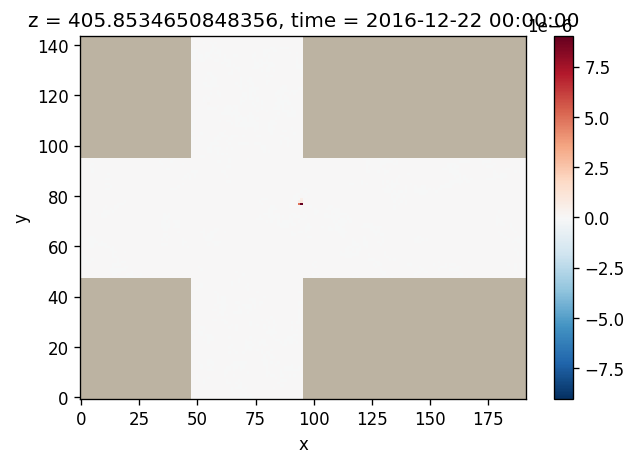

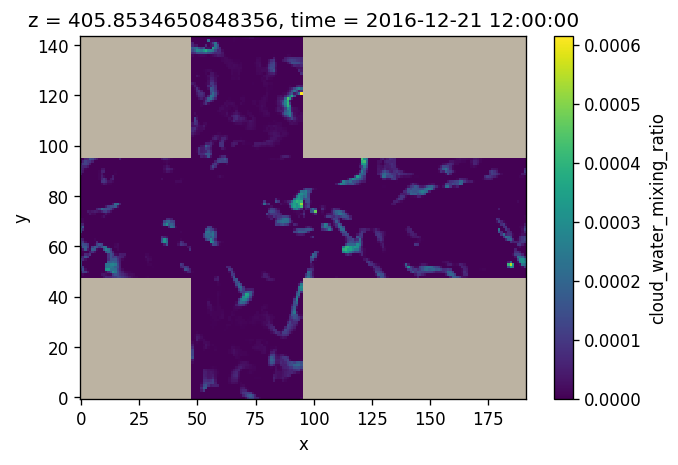

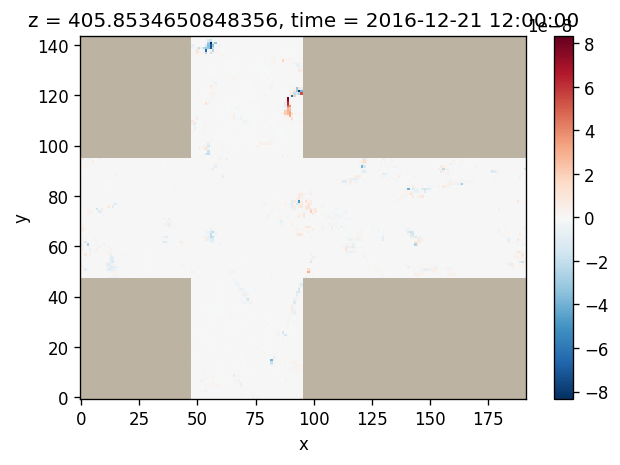

In [11]:
for i in range(0, 9, 4):
    selected = default_data.isel(time=min_skill_default-i, z=abs(default_data.z - 400).argmin())
    c_key = "cloud_water_mixing_ratio"
    plt.figure(dpi=120)
    cross = vcm.cubedsphere.to_cross(selected[c_key], x="x", y="y", tile="tile")
    cross.plot.pcolormesh()
    plt.show()

    dc_key = "tendency_of_cloud_water_due_to_zhao_carr_emulator"
    dc_fort_key = "tendency_of_cloud_water_due_to_zhao_carr_physics"
    plt.figure(dpi=120)
    cross = vcm.cubedsphere.to_cross(selected[dc_key] - selected[dc_fort_key], x="x", y="y", tile="tile")
    cross.plot.pcolormesh()
    plt.show()

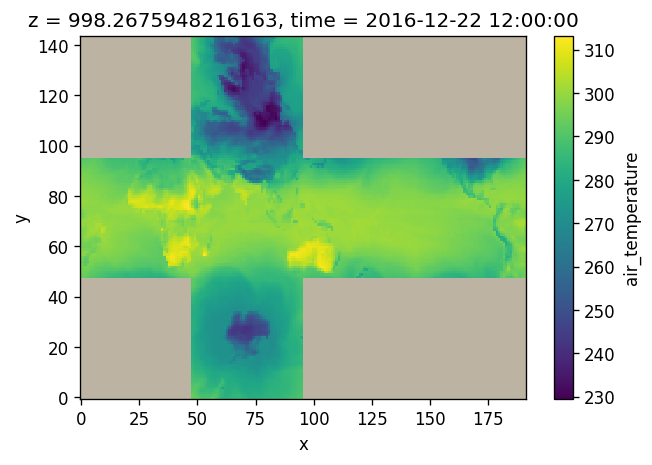

In [14]:
dc_key = "air_temperature"
plt.figure(dpi=120)
cross = vcm.cubedsphere.to_cross(default_data.isel(time=min_skill_default, z=-1)[dc_key], x="x", y="y", tile="tile")
cross.plot.pcolormesh()
plt.show()

In [43]:
def mse(x: xr.DataArray, y, area, dims=None):
    if dims is None:
        dims = set(area.dims)
    return vcm.weighted_average((x - y) ** 2, area, dims)


def skill_improvement(truth, pred, area):
    return 1 - mse(truth, pred, area) / mse(truth, 0, area)


def skill_improvement_column(truth, pred, area):
    return 1 - mse(truth, pred, area).mean() / mse(truth, 0, area).mean()

In [48]:
min_skill = skill_improvement_column(fort_precpd, emu_precpd, default_data.area)
min_skill.compute()

<xarray.DataArray ()>
array(0.03771758, dtype=float32)
Coordinates:
    time     object 2016-12-22 12:00:00

In [50]:
mask = abs(emu_precpd - fort_precpd) < 1e-6
min_skill_masked = skill_improvement_column(fort_precpd.where(mask), emu_precpd.where(mask), default_data.area)
min_skill_masked.compute()

<xarray.DataArray ()>
array(0.7790532, dtype=float32)
Coordinates:
    time     object 2016-12-22 12:00:00

In [57]:
(np.logical_not(mask).sum() / mask.size).compute()

<xarray.DataArray ()>
array(0.00012362)
Coordinates:
    time     object 2016-12-22 12:00:00

In [52]:
np.logical_not(mask).sum().compute()

<xarray.DataArray ()>
array(135)
Coordinates:
    time     object 2016-12-22 12:00:00

In [53]:
z_idx = abs(default_data.z - 400).argmin()
skill_improvement_column(fort_precpd.isel(z=z_idx), emu_precpd.isel(z=z_idx), default_data.area).compute()

<xarray.DataArray ()>
array(0.02035576, dtype=float32)
Coordinates:
    z        float64 405.9
    time     object 2016-12-22 12:00:00

In [54]:
skill_improvement_column(fort_precpd.where(mask).isel(z=z_idx), emu_precpd.where(mask).isel(z=z_idx), default_data.area).compute()

<xarray.DataArray ()>
array(0.71074843, dtype=float32)
Coordinates:
    z        float64 405.9
    time     object 2016-12-22 12:00:00

In [56]:
np.logical_not(mask).isel(z=z_idx).sum().compute()

<xarray.DataArray ()>
array(5)
Coordinates:
    z        float64 405.9
    time     object 2016-12-22 12:00:00